In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange

### Components: PD, MZ Intensity Modulator, Electronic combiner, Optical Attenuator, Readout, CW Laser

In [2]:
class attenuator(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(attenuator, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = pt.Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [3]:
class cw_laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 
    0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(cw_laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [4]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### Constructing the Reservoir Circuit

In [5]:
class ring_reservoir(pt.Network):
    def __init__(self, las_pow = 1, attenuation=0.1, wg_delay=1e-9, wg_phase=0, ring_per=2*np.pi*6.75e-6, tr=0.9,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637):
        super(ring_reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.att = attenuator(attenuation=attenuation, trainable = False) 
        self.laser = cw_laser(Power=las_pow, delay=0) 
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = self.wg2 = pt.Waveguide(0.5*ring_per, loss=0, neff=neff)
        self.fb = pt.Waveguide(neff= neff, length=299792458*wg_delay/2.2637, phase=wg_phase, trainable = False)
        self.link('src:0', '0:mask:1', '0:dc1:2', '0:wg1:1', '1:dc2:3', '0:det')
        self.link('dc1:3', '0:wg2:1', '0:dc2:2', '0:fb:1', '0:att:1', '1:dc1')
print(torch.where(ring_reservoir().free_ports_at)[0])

Buffer containing:
tensor([], dtype=torch.int64)


## Simulation Setup

In [6]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [7]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y

TARGET = narma10_jaeger 

In [8]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 1e9                                  #[1/s] bitrate
Rs = 25*Rb                                #[1/s] samplerate
fc = 2e9                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 2.2111     #1.4440                 #[1] effective index of fiber spool
ng = 2.2637       #1.4626                 #[1] group index of fiber spool
neff_mzm = 2.2111                         #[1] Effective index of lithium niobate (modulator)
ng_mzm = 2.2637                           #[1] Group index of lithium niobate (modulator)
N = 3200                                  #[1] number of bits per bit stream
B = 1                                     #[1] Number of bit streams in training batch
sim_time = N/Rb                           #[s] Simulation time 
wl = 1.55e-6                              #[m] Center Wavelength
Str, Sva, Ste = (10, 2, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance a bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
las_pow = 1                               #[1] Laser Power
wg_delay = 1.0e-9 #equivalent to k=1      #[s] Delay tao(Along with group index below)
fb_att = 0.1                              #[1] Feedback attenuation (strength)
fb_phase=0                                #[1] Feedback phase
Nodes = np.int(Rs/Rb)                     #[1] Number of virtual nodes in the reservoir
mask_vector = 0.1*torch.rand(Nodes)       #Input mask

In [9]:
'''----- BITSTREAM GENERATION -----'''
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)

In [10]:
'''----- BITSTREAMS -----'''

# train streams
trbits = Narma10Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))
trtarget_np = trtarget.numpy()

# validation streams
vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))

# test streams
tebits = Narma10Generator(seed=Ste)(N, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits)) 

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

In [11]:
'''----- Mean Squared Error Function -----'''
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

## Training for Narma10 Task

In [20]:
'''----- Train the Circuit at 1.55um -----'''
Bits = N

for i in range(10):
    wg_phase_= 2*np.pi*0.1*i
    
    for j in range(5):
        fb_att_ = 0.2*j + 0.1
        
        for k in range(5):
            tr_=0.2*k
            ring_res = ring_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay, wg_phase=wg_phase_, 
                                      ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

            with pt.Environment(t=t):
                detected = ring_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
                #ring_res.plot(detected)
                #plt.show()
    
            #Data preparation -- Removing the first 200 bits
            detected_np = detected.numpy()
            detected_np = detected_np.reshape(Bits,Nodes)
            target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
            detected_np_cut = detected_np[200:,:]
            target_now_cut = target_now[200:]
        
            #Regression and Prediction
            regr = linear_model.LinearRegression()
            x = regr.fit(detected_np_cut,target_now_cut)
            y = regr.predict(detected_np_cut)
        
            #Error Calculation
            nmse = 1 - regr.score(detected_np_cut,target_now_cut)
            mse = mse_new(target_now_cut,y,Bits)

            print(f' phase: {wg_phase_}, attenuation: {fb_att_}, transmission = {tr_}, nmse: {nmse}')            

C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.1, transmission = 0.2, nmse: 0.2706441005553666


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.1, transmission = 0.4, nmse: 0.5774536363263801


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6536362324101946


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.1, transmission = 0.8, nmse: 0.6657369249803841


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.375414348037423


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.618444447785609


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6595202210900091


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6658774499317852


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.5, transmission = 0.2, nmse: 0.5111943736253952


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.5, transmission = 0.4, nmse: 0.6470844911795187


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6633402739035706


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.5, transmission = 0.8, nmse: 0.6659092861484333


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6265712874559538


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6619361604976791


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6653394885759684


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6658405972013879


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.9, transmission = 0.2, nmse: 0.6647783662002791


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.9, transmission = 0.4, nmse: 0.6668534552863601


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6657038978394826


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.0, attenuation: 0.9, transmission = 0.8, nmse: 0.6656315621325845


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.1, transmission = 0.2, nmse: 0.32369841618573014


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.1, transmission = 0.4, nmse: 0.5201141496742847


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.651313689220966


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.1, transmission = 0.8, nmse: 0.6670954298662616


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.3605101995767852


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.5763868310370237


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.660576806614636


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6671213158856599


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.5, transmission = 0.2, nmse: 0.44554537827289564


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.5, transmission = 0.4, nmse: 0.6278621636162928


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6657614317427673


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.5, transmission = 0.8, nmse: 0.6666968868246798


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.5787749681593011


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6603223859944028


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6678988002227005


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6659413811061348


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.9, transmission = 0.2, nmse: 0.6647455843816654


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.9, transmission = 0.4, nmse: 0.6689343614037383


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6680668416792207


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 0.6283185307179586, attenuation: 0.9, transmission = 0.8, nmse: 0.6686768859791635


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.1, transmission = 0.2, nmse: 0.3613413799292038


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.1, transmission = 0.4, nmse: 0.5899016175379503


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6555290066439632


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.1, transmission = 0.8, nmse: 0.6652107777564596


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.4246059737844823


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.6193136146808673


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6596112360491351


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6656004047371875


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.5, transmission = 0.2, nmse: 0.511712215541818


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.5, transmission = 0.4, nmse: 0.6413733777819499


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6626954684337495


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.5, transmission = 0.8, nmse: 0.6657425044540469


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.5970746041371261


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6558180202877835


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6648656868374886


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6655371947489512


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.9, transmission = 0.2, nmse: 0.6503353328080838


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.9, transmission = 0.4, nmse: 0.6650068565025906


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6657181965807542


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.2566370614359172, attenuation: 0.9, transmission = 0.8, nmse: 0.6665128807418634


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.1, transmission = 0.2, nmse: 0.4856417520375462


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.1, transmission = 0.4, nmse: 0.6071540407381821


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6371927944915354


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.1, transmission = 0.8, nmse: 0.6624589648883901


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.5381439802200765


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.6095603507116677


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6460093554058128


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6631349907575056


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.5, transmission = 0.2, nmse: 0.5839631573334172


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.5, transmission = 0.4, nmse: 0.6208687742313339


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.654138027858596


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.5, transmission = 0.8, nmse: 0.6636546929132998


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6157464270066949


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6417792431689956


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6597217700082366


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6655918693694854


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.9, transmission = 0.2, nmse: 0.6460362213414843


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.9, transmission = 0.4, nmse: 0.6586405936968778


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6633182785041524


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 1.8849555921538759, attenuation: 0.9, transmission = 0.8, nmse: 0.6663725014112367


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.1, transmission = 0.2, nmse: 0.44644037878944487


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.1, transmission = 0.4, nmse: 0.5394417682426306


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6259137547256732


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.1, transmission = 0.8, nmse: 0.6617146098110136


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.4494981316586676


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.5688109119114159


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6408558569096845


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6637231667955462


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.5, transmission = 0.2, nmse: 0.47496117161216256


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.5, transmission = 0.4, nmse: 0.6051688556604241


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6540059752264635


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.5, transmission = 0.8, nmse: 0.6656265867950144


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.5387497570346684


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6415526394399912


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6636706171147071


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6672577882513451


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.9, transmission = 0.2, nmse: 0.6409874024802639


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.9, transmission = 0.4, nmse: 0.6644224992336903


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6674076848209994


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 2.5132741228718345, attenuation: 0.9, transmission = 0.8, nmse: 0.6692922440742021


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.1, transmission = 0.2, nmse: 0.4022932787665877


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.1, transmission = 0.4, nmse: 0.5740545018540576


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6474573757761648


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.1, transmission = 0.8, nmse: 0.6674589196894187


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.45740950545362824


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.6014778758996586


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6563876816968741


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6672484021552225


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.5, transmission = 0.2, nmse: 0.5311792337330838


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.5, transmission = 0.4, nmse: 0.6301605190106495


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6631609449841812


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.5, transmission = 0.8, nmse: 0.666900079292082


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6068618303338947


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6583609048828102


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6667803641533858


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6664529647333632


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.9, transmission = 0.2, nmse: 0.6622687580059015


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.9, transmission = 0.4, nmse: 0.667694271141485


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6668545463937815


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.141592653589793, attenuation: 0.9, transmission = 0.8, nmse: 0.6663413054846535


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.1, transmission = 0.2, nmse: 0.5191385292114454


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.1, transmission = 0.4, nmse: 0.5757110132024801


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6306990971639991


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.1, transmission = 0.8, nmse: 0.6617395797450226


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.5274925800337301


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.5988627186383269


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6440822639476795


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6637357080367976


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.5, transmission = 0.2, nmse: 0.5554798340113201


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.5, transmission = 0.4, nmse: 0.6257433065613157


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6558083958127784


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.5, transmission = 0.8, nmse: 0.665824867422817


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6046098174419343


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6508298353362996


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6646661791811959


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6676408238651519


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.9, transmission = 0.2, nmse: 0.6549398561607682


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.9, transmission = 0.4, nmse: 0.6655563223728886


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6675484170174485


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 3.7699111843077517, attenuation: 0.9, transmission = 0.8, nmse: 0.6698213170709759


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.1, transmission = 0.2, nmse: 0.46929787218352437


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.1, transmission = 0.4, nmse: 0.6092470997865231


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6377605655528611


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.1, transmission = 0.8, nmse: 0.6627184487979129


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.5265511226431998


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.6169199829983151


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6464541195510596


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6634502722173345


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.5, transmission = 0.2, nmse: 0.5744189152211137


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.5, transmission = 0.4, nmse: 0.6300453224032464


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6544877478842633


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.5, transmission = 0.8, nmse: 0.6639962094798528


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6105558881633337


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6465001216866689


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6601150370860336


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6655230076589229


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.9, transmission = 0.2, nmse: 0.6453448132588717


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.9, transmission = 0.4, nmse: 0.6601739344964214


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6637487259669503


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 4.39822971502571, attenuation: 0.9, transmission = 0.8, nmse: 0.665955906990192


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.1, transmission = 0.2, nmse: 0.3524131598244904


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.1, transmission = 0.4, nmse: 0.5844427570298402


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6554777161248527


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.1, transmission = 0.8, nmse: 0.6642842661509271


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.41882579763214056


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.6140946087436869


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6597712840004386


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6647019453832775


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.5, transmission = 0.2, nmse: 0.5092463012214808


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.5, transmission = 0.4, nmse: 0.6395200298628785


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6628017458867919


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.5, transmission = 0.8, nmse: 0.6648563831308927


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.6009143686313092


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6563354212828675


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6649064427529219


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6649954476634694


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.9, transmission = 0.2, nmse: 0.6560760367350079


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.9, transmission = 0.4, nmse: 0.66457817100269


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6654128406376839


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.026548245743669, attenuation: 0.9, transmission = 0.8, nmse: 0.6662274785614125


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.1, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.1, transmission = 0.2, nmse: 0.2938880216024977


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.1, transmission = 0.4, nmse: 0.4732615533519504


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.1, transmission = 0.6000000000000001, nmse: 0.6513565044989003


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.1, transmission = 0.8, nmse: 0.6683129514126739


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.30000000000000004, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.30000000000000004, transmission = 0.2, nmse: 0.31077097445493207


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.30000000000000004, transmission = 0.4, nmse: 0.5435536768395955


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.30000000000000004, transmission = 0.6000000000000001, nmse: 0.6615498034643796


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.30000000000000004, transmission = 0.8, nmse: 0.6682864053532136


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.5, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.5, transmission = 0.2, nmse: 0.38878051881207343


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.5, transmission = 0.4, nmse: 0.6092143702434792


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.5, transmission = 0.6000000000000001, nmse: 0.6669584257608442


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.5, transmission = 0.8, nmse: 0.6677748314118018


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.7000000000000001, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.7000000000000001, transmission = 0.2, nmse: 0.5472158532542075


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.7000000000000001, transmission = 0.4, nmse: 0.6534064924168599


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.7000000000000001, transmission = 0.6000000000000001, nmse: 0.6683682763656246


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.7000000000000001, transmission = 0.8, nmse: 0.6667443331333265


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.9, transmission = 0.0, nmse: 0.7483218000823836


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.9, transmission = 0.2, nmse: 0.6610981819533571


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.9, transmission = 0.4, nmse: 0.6684387700709362


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.9, transmission = 0.6000000000000001, nmse: 0.6677362972315708


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


 phase: 5.654866776461628, attenuation: 0.9, transmission = 0.8, nmse: 0.6695060208490948


## Testing at the training wavelength for Validation set

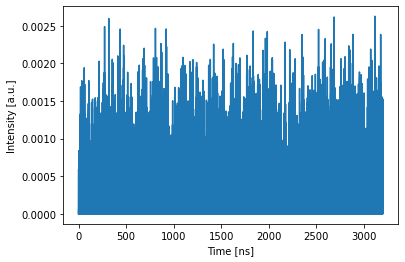

 phase: 0, attenuation: 0, transmission = 0.2, nmse: 0.23116393719697093


C:\Users\mabdalla\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


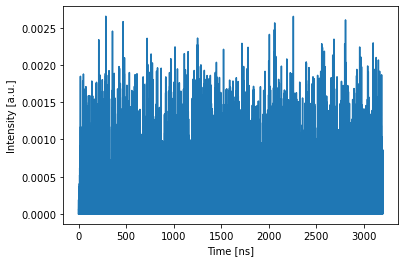

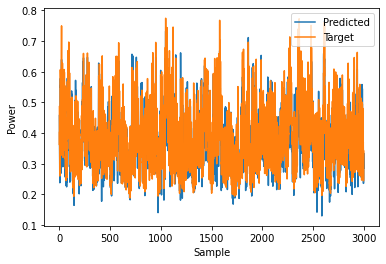

 phase: 0, attenuation: 0, transmission = 0.2, nmse: 0.22033141743101314


In [19]:
'''----- Training -----'''
wg_phase_=0
tr_=0.2
fb_att_=0

ring_res_test = ring_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

with pt.Environment(t=t):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res.plot(detected)
    plt.show()
    
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f' phase: {wg_phase_}, attenuation: {fb_att_}, transmission = {tr_}, nmse: {nmse}')            


'''----- Validation Test -----'''
with pt.Environment(t=t):
    detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected_va)
    plt.show()

#Data preparation -- Removing the first 200 bits
detected_va_np = detected_va.numpy()
detected_va_np = detected_va_np.reshape(Bits,Nodes)
target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
detected_va_np_cut = detected_va_np[200:,:]
target_va_now_cut = target_va_now[200:]

#Prediction
y_va = regr.predict(detected_va_np_cut)

#Error Calculation
nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
mse_va = mse_new(target_va_now_cut,y_va,Bits)

#Plots
plt.plot(y_va,label='Predicted')
plt.plot(target_va_now_cut,label='Target')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.show()

print(f' phase: {wg_phase_}, attenuation: {fb_att_}, transmission = {tr_}, nmse: {nmse_va}')            

In [ ]:
'''----- Scatter Plot of predicted vs expected ------'''

plt.scatter(y_va, target_va_now_cut, marker='.', alpha=0.2)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Expected', fontsize=12)
plt.show()

## Sweeping Across Wavelength:
### Validation Set Performance

In [ ]:
'''----- Sweep the Circuit at several wavelengths -----'''
wavelengths = 1e-6*np.linspace(1.3,1.8,11) #[m] Wavelengths to sweep over
#wg_ng = np.array([1.4616 ,1.4617, 1.4618, 1.4620, 1.4623, 1.4626, 1.4629, 1.4633, 1.4638, 1.4643, 1.4648])
#wg_neff = np.array([1.4469, 1.4464, 1.4458, 1.4452, 1.4446,1.4440, 1.4434, 1.4428, 1.4422, 1.4415, 1.4409])
ng_mzm = np.array([2.2744, 2.2715, 2.2690, 2.2669, 2.2651, 2.2637, 2.2625, 2.2615, 2.2608, 2.2602, 2.2599])
neff_mzm = np.array([2.2204, 2.2184, 2.2164, 2.2146, 2.2128, 2.2111, 2.2094, 2.2078, 2.2062, 2.2046, 2.2030])
nmse = np.zeros_like(wavelengths)

for i in range(11):
    
    Reservoir_oe_multiwl = oe_reservoir(gain=gain,wl0=wavelengths[i], las_pow=las_pow, 
                            attenuation=att, wg_delay=wg_delay, wg_ng=ng_mzm[i], wg_neff=neff_mzm[i], 
                            mask_vector=mask_vector, nodes=Nodes, weights=weights_, 
                            bias=bias, neff_mzm=neff_mzm[i], ng_mzm=ng_mzm[i])

    with pt.Environment(t=t,wl=wavelengths[i]):
        detected_va_wl = Reservoir_oe_multiwl(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        Reservoir_oe_multiwl.plot(detected_va_wl)
        plt.show()

    #Data preparation -- Removing the first 200 bits
    detected_va_wl_np = detected_va_wl.numpy()
    detected_va_wl_np = detected_va_wl_np.reshape(Bits,Nodes)
    #target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
    detected_va_wl_np_cut = detected_va_wl_np[200:,:]
    #target_va_wl_now_cut = target_va_now[200:]

    #Prediction
    y_va_wl = regr.predict(detected_va_wl_np_cut)

    #Error Calculation
    nmse_va_wl = 1 - regr.score(detected_va_wl_np_cut,target_va_now_cut)
    mse_va_wl = mse_new(target_va_now_cut,y_va_wl,Bits)

    #Plots
    plt.plot(y_va_wl,label='Predicted')
    plt.plot(target_va_now_cut,label='Target')
    plt.legend(loc='upper right')
    plt.xlabel('Sample')
    plt.ylabel('Power')
    plt.show()
    nmse[i] = nmse_va_wl
    print(f' wavelength: {wavelengths[i]}, mse: {mse_va_wl}, nmse: {nmse_va_wl}')    

In [ ]:
plt.plot(wavelengths,nmse)
plt.xlabel('Wavelengths')
plt.ylabel('NMSE')
plt.show()

In [ ]:
torch.manual_seed(2)
x=torch.rand([2,2])
x
y=torch.transpose(x,0,1)
print(y)
print(x)

In [ ]:
dt = 1e-14 #[s]
total_time = 2000*dt #[s]
time = np.arange(0, total_time, dt)
c = 299792458 #[m/s]
ring_per = 2*np.pi*6.75e-6 #[m] Perimeter of ring
transmission = 0.7 #[]
neff_lnb = neff_mzm
wavelengths = 1e-6*np.linspace(1.5, 1.550, 1000) #[m]

In [ ]:
with pt.Network() as nw:
    nw.term_in = pt.Source()
    nw.term_thru = nw.term_add = nw.term_drop = pt.Detector()
    nw.dc1 = nw.dc2 = pt.DirectionalCoupler(1-transmission)
    nw.wg1 = nw.wg2 = pt.Waveguide(0.5*ring_per, loss=0, neff=neff_lnb)
    nw.link('term_in:0', '0:dc1:2', '0:wg1:1', '1:dc2:3', '0:term_drop')
    nw.link('term_thru:0', '1:dc1:3', '0:wg2:1', '0:dc2:2', '0:term_add')

In [ ]:
with pt.Environment(wl=np.mean(wavelengths), t=time):
    detected = nw(source=1)
    nw.plot(detected);

In [ ]:
with pt.Environment(wl=wavelengths, freqdomain=True):
    detected = nw(source=1)
    nw.plot(detected)

In [ ]:
with pt.Network() as nw2:
    nw2.src = pt.Source()
    nw2.det = pt.Detector()
    nw2.soa = pt.AgrawalSoa(L=0.005, W=2e-06, H=2e-07, N0=1e+24, a=2.7e-20, I=0.18666666666666668, 
                            tc=3e-10, gamma=0.3, alpha=5.0, neff=2.34, ng=3.75, wl=1.55e-06, name=None)
    #nw2.wg = pt.Waveguide(ring_length, loss=0, neff=2.86)
    nw2.link('src:0' , '0:soa:1', '0:det')
    

In [ ]:
with pt.Environment(wl=np.mean(wavelengths), t=50*time):
    detected = nw2(source=1)
    nw2.plot(detected);

In [ ]:
class add_drop(pt.Network):
    def __init__(self):
        super(add_drop,self).__init__()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-transmission)
        self.wg1 = self.wg2 = pt.Waveguide(0.5*ring_per, loss=0, neff=neff_lnb)
        self.link('0:dc1:2', '0:wg1:1', '1:dc2:3')
        self.link('1:dc1:3', '0:wg2:1', '0:dc2:2')

print(torch.where(add_drop().free_ports_at)[0])

In [ ]:
Bits = N
        
ring_res = ring_reservoir(gain=gain, wl0=1.55e-6, las_pow=las_pow, attenuation=att, wg_delay=wg_delay, wg_ng=ng, wg_neff=neff, mask_vector=mask_vector, nodes=Nodes, weights=weights_, bias=bias, neff_mzm=neff_mzm, ng_mzm=ng_mzm)

with pt.Environment(t=t):
    detected = Reservoir_oe(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    Reservoir_oe.plot(detected)
    plt.show()
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f' attenuation: {att}, gain: {gain}, mse: {mse}, nmse: {nmse}')  